In [1]:
import os
from collections import OrderedDict
import numpy as np
import h5py

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 300

In [2]:
mshfile = 'seismic.msh'
hdffile = 'masks.hdf5'
cellsize = 5

In [3]:
with open(mshfile, 'r') as fp:
    nx, ny, nz = tuple((int(item) for item in fp.readline().strip().split()))
    ox, oy, oz = tuple((float(item) for item in fp.readline().strip().split()))
if not os.path.isfile(hdffile):
    %run make_seismodels.py
masks = h5py.File(hdffile)
dims = (nz, ny, nx)
origin = (oz, oy, ox)
ez = oz - nz * cellsize
ey = oy + ny * cellsize
ex = ox + nx * cellsize

In [4]:
backgroundDensity = 2700.
densities = OrderedDict([
    ('till',    2700.),
    ('xvk',     2700.),
    ('pk1',     2700.),
    ('pk2',     2700.),
    ('pk3',     2700.),
    ('hk',      2700.),
    ('vk',      2700.),
    ('air',     1.225),
])

cTop = 5100.
cBot = 6000.
tillAdjust = 500
kimAdjust = 1000
velocities = OrderedDict([
    ('till',    2000.),
    ('xvk',     4000.),
    ('pk1',     4300.),
    ('pk2',     4300.),
    ('pk3',     4300.),
    ('hk',      4000.),
    ('vk',      4000.),
    ('air',     343.),
])

In [5]:
# Background velocity
vel = np.zeros(dims, np.float64)
vel += np.flipud(np.linspace(cTop, cBot, nz).reshape((nz,1,1)))

In [6]:
# Till layer velocity
tlm = np.array(masks['till'])
tlv = np.ones(dims, np.float64) * velocities['till'] + np.flipud(
    np.hstack([
        -np.ones((10,)),
        np.linspace(-1, 1, 20),
        np.ones((nz-30,)),
    ]).reshape((nz, 1, 1)),
) * tillAdjust
vel = vel * (True ^ tlm) + tlv * tlm

In [7]:
# Remaining kimberlite layers
klv = np.ones(dims, np.float64) * np.flipud(np.linspace(-0.2, 1, nz).reshape((nz,1,1))) * kimAdjust
for key in velocities.keys()[1:]:
    mask = np.array(masks[key])
    vel[mask] = (velocities[key] + klv)[mask]

In [8]:
# Compute ground surface
surf = np.array([np.argwhere(col)[0] for col in (np.array(masks['air']).reshape((nz, nx*ny))).T]).reshape((ny, nx))

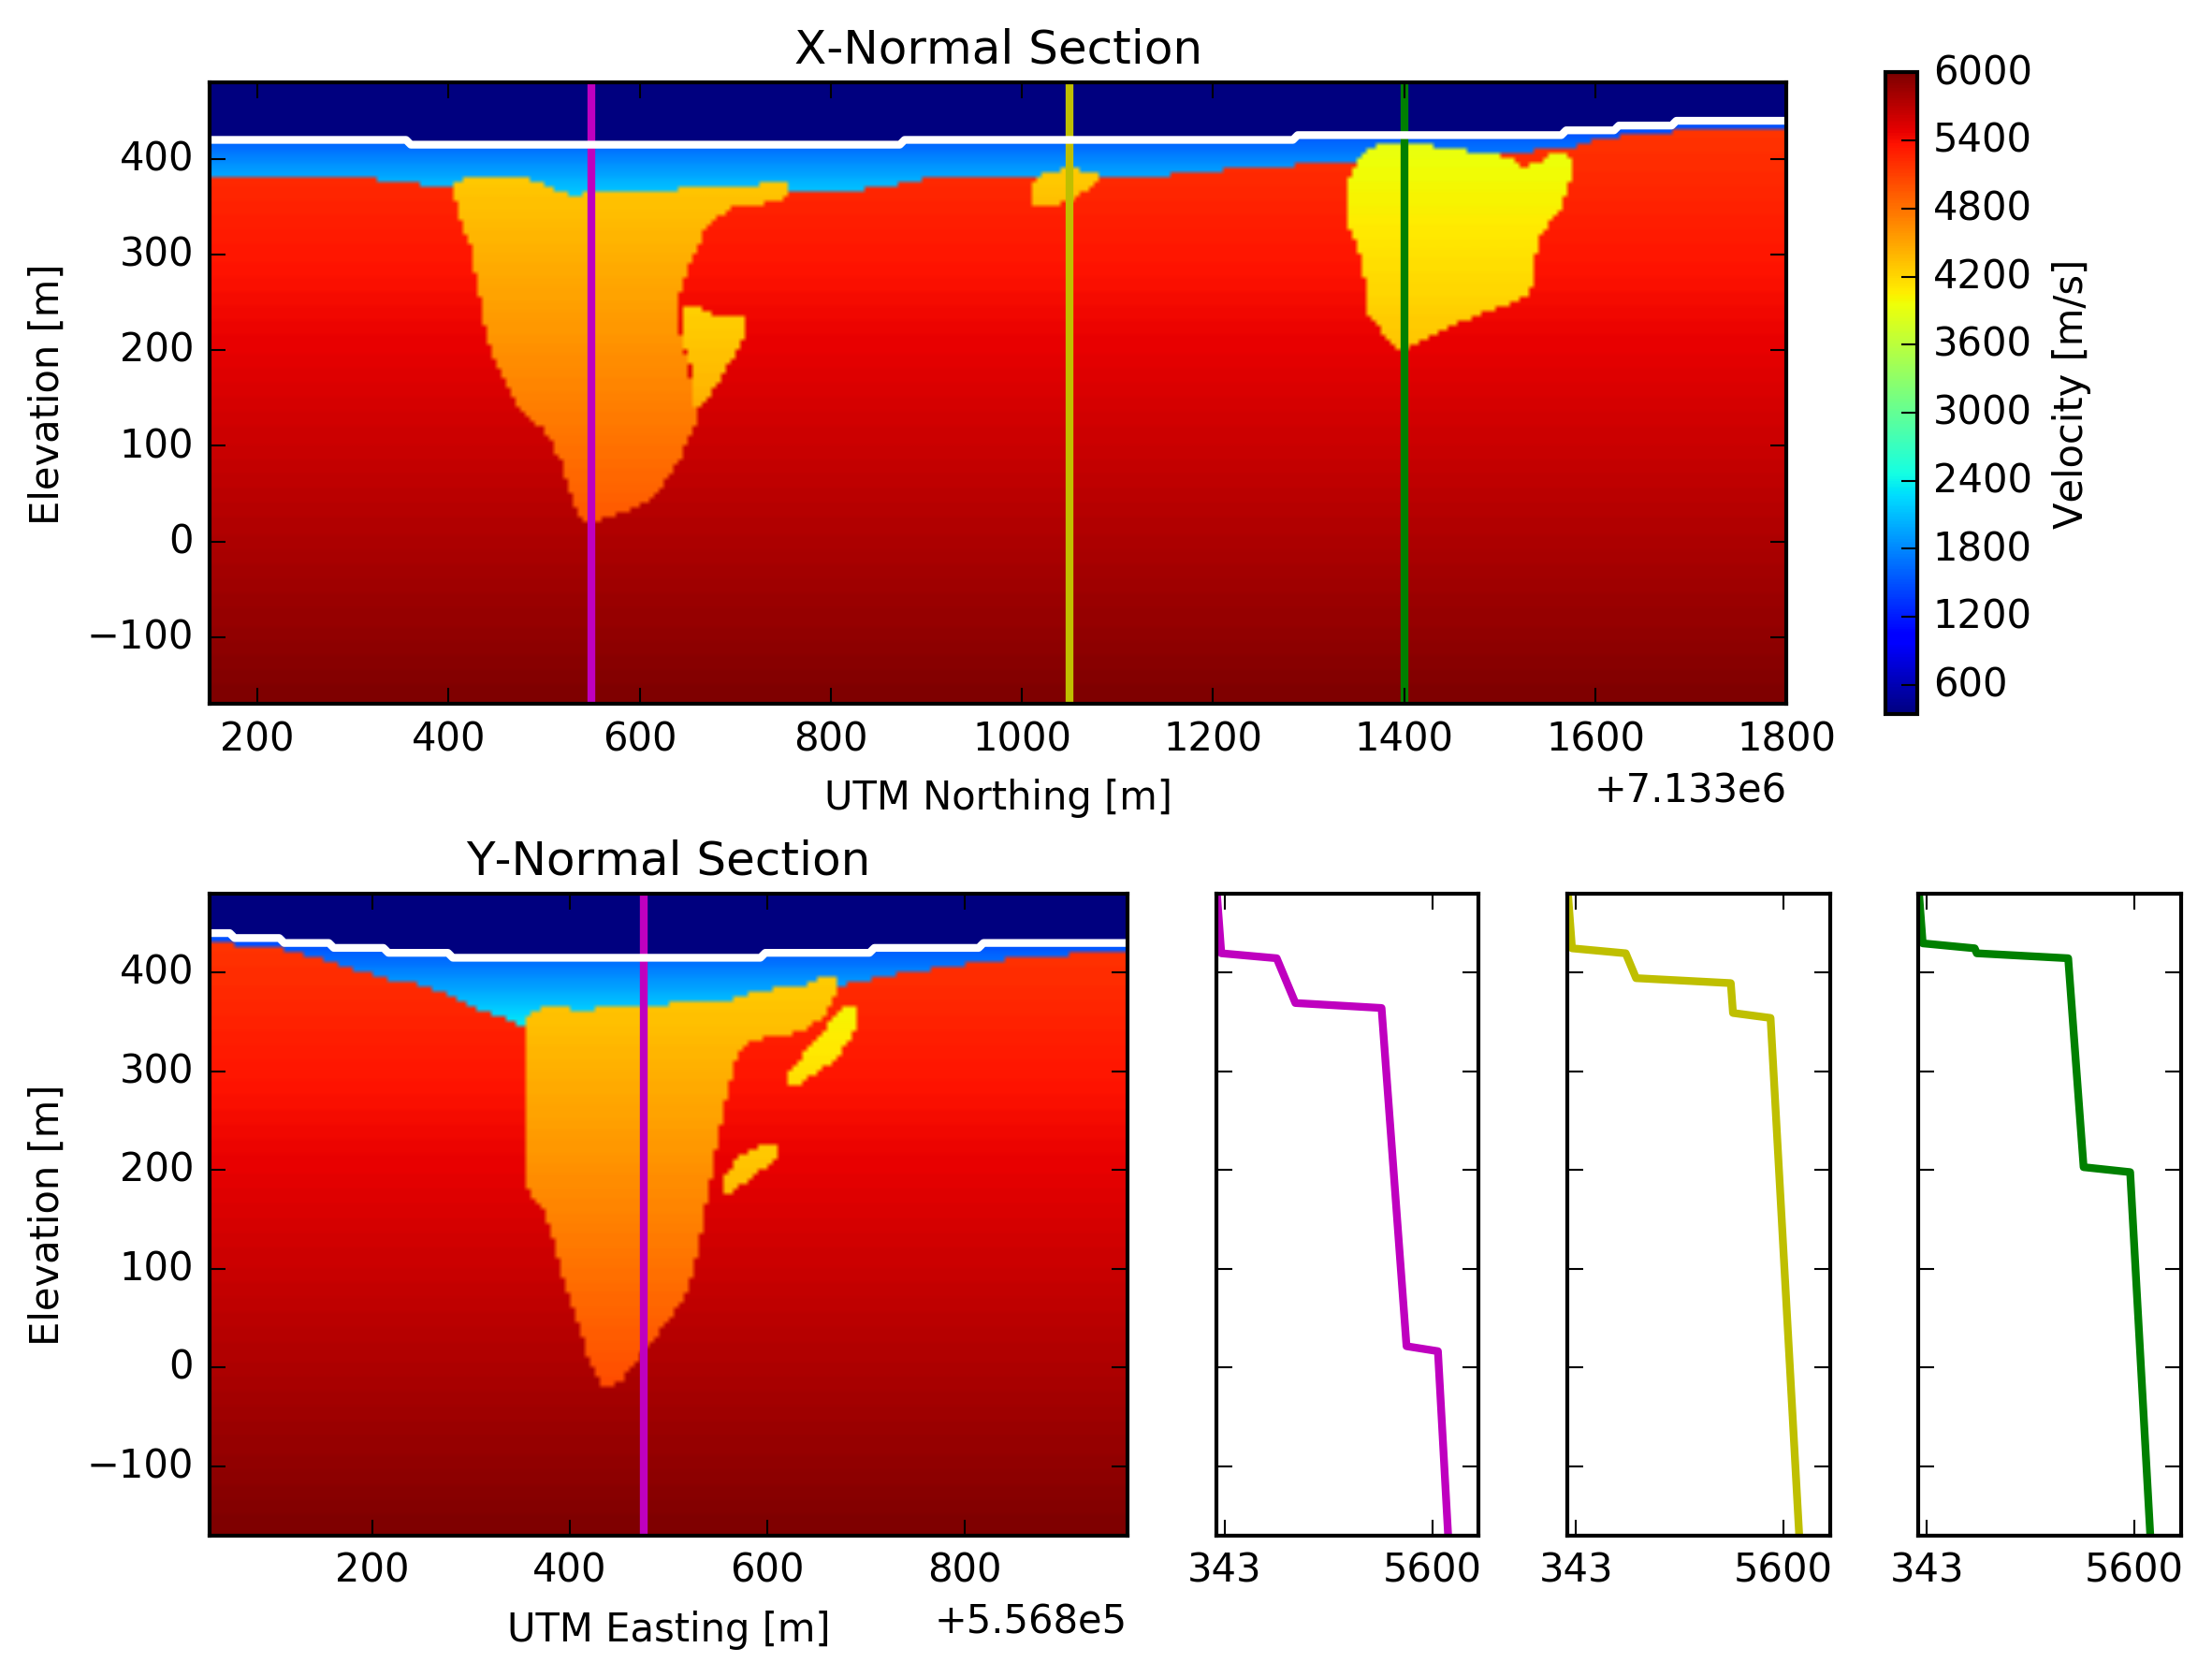

In [9]:
xplane = 95
yplane = 80
yextr2 = 180
yextr3 = 250

velLabels = [343, 5600]

plotOpts = {
    'vmin': velocities['air'],
    'vmax': cBot,
    'cmap': cm.jet,
}
logAspect=25

elev = np.linspace(ez, oz, nz)
extr1 = vel[:,yplane,xplane]
extr2 = vel[:,yextr2,xplane]
extr3 = vel[:,yextr3,xplane]

fig = plt.figure(figsize=(8,6))
gs = plt.GridSpec(2, 4, width_ratios=(7,2,2,2), height_ratios=(1,1))

ax1 = fig.add_subplot(gs[0,:], aspect=1)
plt.imshow(vel[:,:,xplane], extent=[oy, ey, oz, ez], **plotOpts)
cbax = plt.colorbar()
cbax.set_label('Velocity [m/s]')
ax1.invert_yaxis()
ax1.plot(np.linspace(oy, ey, ny), surf[:,xplane]*cellsize + ez, 'w-', linewidth=2)
plt.vlines(oy + yplane*cellsize, ez, oz, 'm', linewidth=2)
plt.vlines(oy + yextr2*cellsize, ez, oz, 'y', linewidth=2)
plt.vlines(oy + yextr3*cellsize, ez, oz, 'g', linewidth=2)
plt.axis((oy, ey, ez, oz))
plt.xlabel('UTM Northing [m]')
plt.ylabel('Elevation [m]')
plt.title('X-Normal Section')

ax2 = fig.add_subplot(gs[1,0], aspect=1)
plt.imshow(vel[:,yplane,:], extent=[ox, ex, oz, ez], **plotOpts)
ax2.invert_yaxis()
ax2.plot(np.linspace(ox, ex, nx), surf[yplane,:]*cellsize + ez, 'w-', linewidth=2)
plt.vlines(ox + xplane*cellsize, ez, oz, 'm', linewidth=2)
plt.xlabel('UTM Easting [m]')
plt.ylabel('Elevation [m]')
plt.title('Y-Normal Section')
ax2.axis((ox, ex, ez, oz))

ax3 = fig.add_subplot(gs[1,1], sharey=ax2, aspect=logAspect)
plt.plot(extr1, elev, 'm', linewidth=2)
ax3.axis((velocities['air'], cBot*1.1, oz, ez))
# ax3.yaxis.set_ticklabels([])

ax4 = fig.add_subplot(gs[1,2], sharey=ax2, sharex=ax3, aspect=logAspect)
plt.plot(extr2, elev, 'y', linewidth=2)
# ax4.yaxis.set_ticklabels([])

ax5 = fig.add_subplot(gs[1,3], sharey=ax2, sharex=ax3, aspect=logAspect)
plt.plot(extr3, elev, 'g', linewidth=2)
# ax5.yaxis.set_ticklabels([])

for label in ax3.get_yticklabels() + ax4.get_yticklabels() + ax5.get_yticklabels():
    label.set_visible(False)

ax3.xaxis.set_ticks(velLabels)
ax3.axis((velocities['air']*0.9, cBot*1.1, oz, ez))
ax3.invert_yaxis()

gs.tight_layout(fig)